# Imports

In [12]:
import numpy as np
import os
import sys
import pickle
import scipy
import scipy.stats as stats
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api
import statsmodels as sm
import statsmodels.stats.multitest as smt

## Helper Functions

In [13]:
%store -r analysis_hf
sys.path.insert(0, analysis_hf)

import nodeMapping as nm
import normalize as norm

# Set Directory Paths

In [14]:
# Directory path to load preconstructed Atlas Data
%store -r baseDir

# Directory path to load formatted Pathology Data
%store -r path_dataDir
# Directory path to save Calcualted Analysis Data - Pathology
%store -r path_CalData

# Directory path to load formatted Thickness At Path Data
%store -r thickAtPath_dataDir
# Directory path to save Calcualted Analysis Data
%store -r thickAtPath_CalData
# Directory path to save Figures
%store -r thickAtPath_Fig

# Loading

## Loading the preconstructed atlas data

In [15]:
# loads the preconstructed Atlas data
NetworkDataGeneral = scipy.io.loadmat(os.path.join(baseDir, 'NetworkAnalysisGeneral', 'FTDGeneralData_20221114.mat'))

## Loading Volume At Path W Score (TAU, TDP) - Dropped

In [16]:
# TAUVolumeAtPath_w_Drop
with open(os.path.join(thickAtPath_CalData, 'TAUVolumeAtPath_w_Drop.pkl'), 'rb') as f:
    TAUVolumeAtPath_w_Drop = pickle.load(f)
f.close()

# TDPVolumeAtPath_w_Drop
with open(os.path.join(thickAtPath_CalData, 'TDPVolumeAtPath_w_Drop.pkl'), 'rb') as f:
    TDPVolumeAtPath_w_Drop = pickle.load(f)
f.close()

## Loading Dropped Index (=few observations)

In [17]:
# TAU_missing_index
with open(os.path.join(path_CalData, 'TAU_missing_index.pkl'), 'rb') as f:
    TAU_missing_index = pickle.load(f)
f.close()

# TDP_missing_index
with open(os.path.join(path_CalData, 'TDP_missing_index.pkl'), 'rb') as f:
    TDP_missing_index = pickle.load(f)
f.close()

## Loading Pathology Labels (TAU, TDP) - Dropped

In [18]:
# pathNames_TAU_Drop
with open(os.path.join(path_CalData, 'pathNames_TAU_Drop.pkl'), 'rb') as f:
    pathNames_TAU_Drop = pickle.load(f)
f.close()

# pathNames_TDP_Drop
with open(os.path.join(path_CalData, 'pathNames_TDP_Drop.pkl'), 'rb') as f:
    pathNames_TDP_Drop = pickle.load(f)
f.close()

## Loading pathCoM (TAU, TDP) - Dropped

In [19]:
# CoM_TAU_Drop
with open(os.path.join(path_dataDir, 'CoM_TAU_Drop.pkl'), 'rb') as f:
    CoM_TAU_Drop = pickle.load(f)
f.close()

# CoM_TDP_Drop
with open(os.path.join(path_dataDir, 'CoM_TDP_Drop.pkl'), 'rb') as f:
    CoM_TDP_Drop = pickle.load(f)
f.close()

## Data Distribution

In [20]:
def dist_boxplot(data, labels, min_val, max_val, title, x_label, y_label):
    # Reorder the data and labels (group by regions L, R)
    new_order = [i//2 if i % 2 == 0 else int((i//2) + (len(labels)/2)) for i in range(len(labels))]
    reordered_data = data[:, new_order]
    reordered_labels = [labels[i] for i in new_order]
    
    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(12, 6))

    # Create boxplots for each column
    boxplot = sns.boxplot(data=reordered_data, width=0.5, ax=ax, fliersize=0, boxprops=dict(alpha=.3))

    # Add individual data points with aligned x-values
    for i, col_data in enumerate(reordered_data.T):
        # Handle NaNs
        col_data = col_data[~np.isnan(col_data)]

        jitter = np.random.normal(0, 0.1, size=len(col_data))  # Add jitter for better visualization
        x = np.full_like(col_data, i) + jitter
        ax.scatter(x, col_data, alpha=0.5, color='blue', s=5)

     # Add vertical lines every two columns
    for i in range(1, int(len(labels)-2), 2):
        ax.axvline(x=i + 0.5, color='grey', linestyle='--', lw=0.5)
        
    # Set x-axis labels
    ax.set_xticks(np.arange(0, len(labels)))
    ax.set_xticklabels(reordered_labels, rotation=45, ha='right')  # Use NeuN_Labels as x-axis labels

    # Set y-axis limits (replace these values with your desired limits)
    y_min_limit = min_val  # Minimum limit
    y_max_limit = max_val  # Maximum limit
    ax.set_ylim(y_min_limit, y_max_limit)

    # Set plot title and labels
    ax.set_title(title)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)

    # Show the plot
    plt.tight_layout()
    plt.show()

In [21]:
# min max
all_values = np.concatenate([TAUVolumeAtPath_w_Drop.flatten(), TDPVolumeAtPath_w_Drop.flatten()])
min_val = np.nanmin(all_values)
max_val = np.nanmax(all_values)
buffer = (max_val-min_val) * 0.1

min_val = min_val - buffer
max_val = max_val + buffer

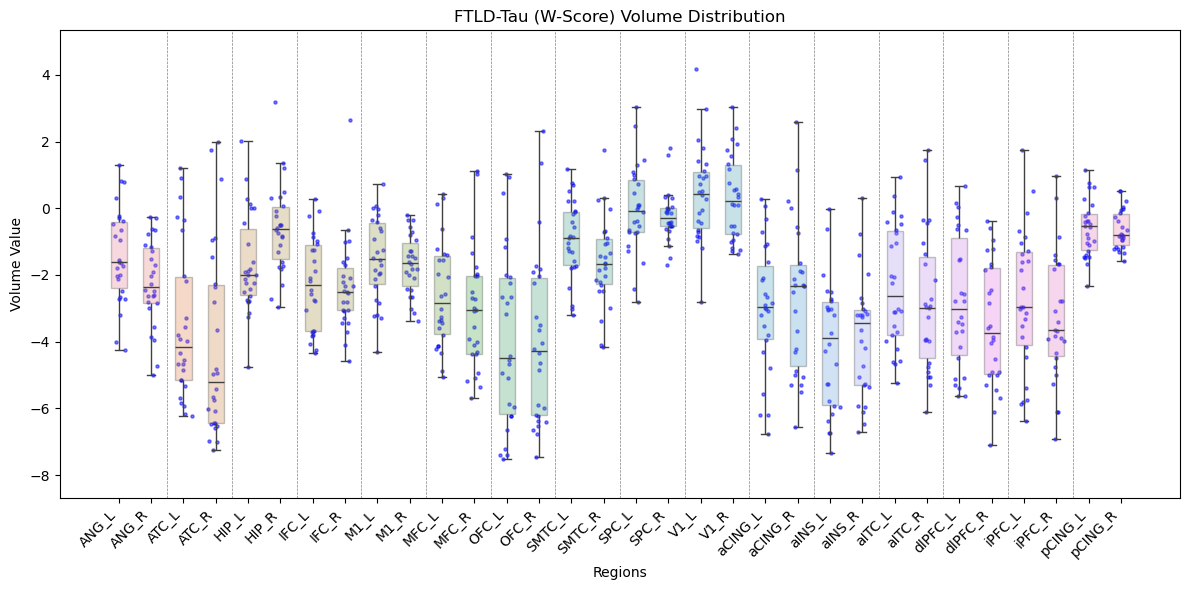

In [22]:
dist_boxplot(TAUVolumeAtPath_w_Drop, pathNames_TAU_Drop, min_val, max_val, 'FTLD-Tau (W-Score) Volume Distribution', 'Regions', 'Volume Value')

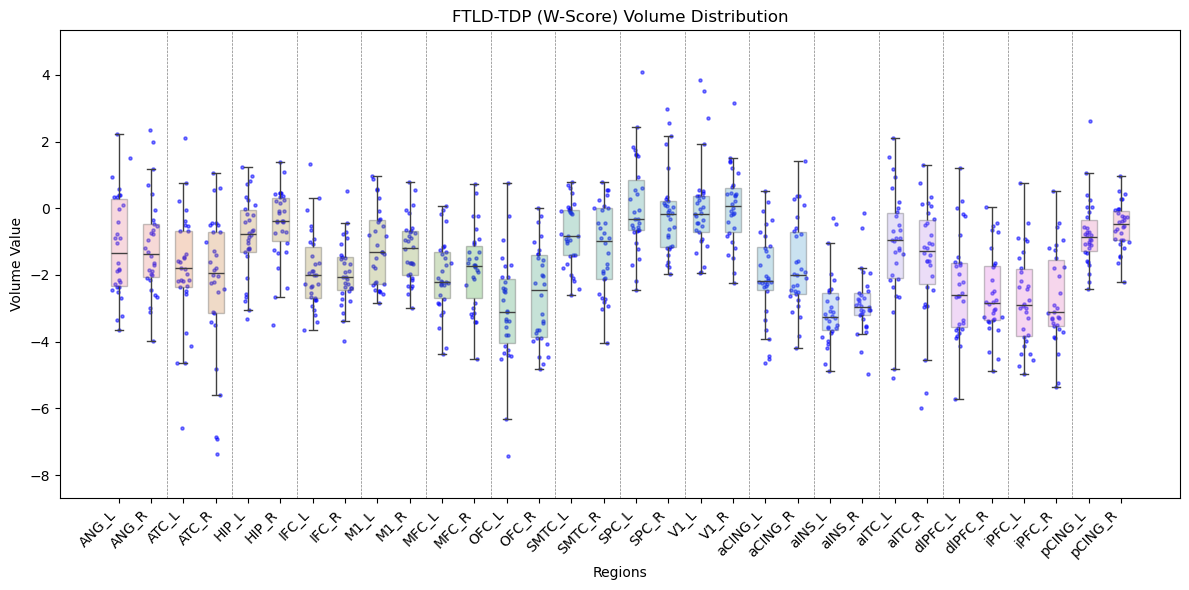

In [23]:
dist_boxplot(TDPVolumeAtPath_w_Drop, pathNames_TDP_Drop, min_val, max_val, 'FTLD-TDP (W-Score) Volume Distribution', 'Regions', 'Volume Value')

# T-test between TAU vs TDP

### 01/31/2024

In [24]:
# 2-sided test

def t_test_func(left_data, right_data, LabelNames):
    # Perform t-test for each column
    p_values = [stats.ttest_ind(left_data[:, i], right_data[:, i], equal_var=False, nan_policy='omit', alternative='two-sided').pvalue for i in range(left_data.shape[1])]

    # Identifying indices with NaN p-values
    nan_indices = [i for i, p in enumerate(p_values) if p is None or np.isnan(p)]
    valid_indices = [i for i in range(len(p_values)) if i not in nan_indices]
    valid_p_values = [p_values[i] for i in valid_indices]

    # Multiple comparison correction for non-NaN p-values
    corrected_p_values = smt.multipletests(valid_p_values, method='fdr_bh')[1]

    # Initialize a new array with NaNs and replace non-NaN positions with corrected p-values
    final_p_values = np.full(len(p_values), np.nan)
    for i, val in zip(valid_indices, corrected_p_values):
        final_p_values[i] = val

    # Region names for output
    region_names = LabelNames

    # Output the corrected p-values
    for i, p_val in enumerate(final_p_values):
        if np.isnan(p_val):
            print(f"{region_names[i]:<10}: p-value cannot be computed")
        else:
            difference_status = "NOT significantly different" if p_val > 0.05 else "significantly different"
            print(f"{region_names[i]:<10}: Corrected p-value = {p_val:.4f} / {difference_status}")



In [25]:
print("T-Test for Volume: TAU vs TDP")
t_test_func(TAUVolumeAtPath_w_Drop, TDPVolumeAtPath_w_Drop, pathNames_TAU_Drop)

T-Test for Volume: TAU vs TDP
ANG_L     : Corrected p-value = 0.5735 / NOT significantly different
ATC_L     : Corrected p-value = 0.0577 / NOT significantly different
HIP_L     : Corrected p-value = 0.1030 / NOT significantly different
IFC_L     : Corrected p-value = 0.4201 / NOT significantly different
M1_L      : Corrected p-value = 0.4342 / NOT significantly different
MFC_L     : Corrected p-value = 0.3256 / NOT significantly different
OFC_L     : Corrected p-value = 0.3310 / NOT significantly different
SMTC_L    : Corrected p-value = 0.7391 / NOT significantly different
SPC_L     : Corrected p-value = 0.8292 / NOT significantly different
V1_L      : Corrected p-value = 0.4515 / NOT significantly different
aCING_L   : Corrected p-value = 0.1141 / NOT significantly different
aINS_L    : Corrected p-value = 0.0692 / NOT significantly different
aITC_L    : Corrected p-value = 0.0592 / NOT significantly different
dlPFC_L   : Corrected p-value = 0.4515 / NOT significantly different
iPFC

# T-test between TAU vs TDP

## Checking if there is region differences between TAU and TDP due to Drop in Observations

In [9]:
print(TAU_missing_index)
print(TDP_missing_index)

# --> There is no difference

[ 7  8 17 19 27 28 37 39]
[ 7  8 17 19 27 28 37 39]


In [10]:
# Number of regions of Pathology (N = 40)
N = TAUVolumeAtPath_w_Drop.shape[1]

## T-test. Since the sample numbers are different between TAU and TDP, we would perform Welch's t-test

In [11]:
TAU_gt_TDP_Ttest_stat_list = []
TAU_gt_TDP_Ttest_pval_list = []

TDP_gt_TAU_Ttest_stat_list = []
TDP_gt_TAU_Ttest_pval_list = []


for i in range(N):
    TAU_data = TAUVolumeAtPath_w_Drop[:, i]
    TDP_data = TDPVolumeAtPath_w_Drop[:, i]

    # ignore NaN Values in T-test
    TAU_gt_TDP_Ttest = stats.ttest_ind(a=TAU_data, b=TDP_data, equal_var=False, alternative='greater', nan_policy='omit')
    TDP_gt_TAU_Ttest = stats.ttest_ind(a=TAU_data, b=TDP_data, equal_var=False, alternative='less', nan_policy='omit')

    TAU_gt_TDP_Ttest_stat = TAU_gt_TDP_Ttest[0]
    TAU_gt_TDP_Ttest_pval = TAU_gt_TDP_Ttest[1]

    TAU_gt_TDP_Ttest_stat_list.append(TAU_gt_TDP_Ttest_stat)
    TAU_gt_TDP_Ttest_pval_list.append(TAU_gt_TDP_Ttest_pval)

    TDP_gt_TAU_Ttest_stat = TDP_gt_TAU_Ttest[0]
    TDP_gt_TAU_Ttest_pval = TDP_gt_TAU_Ttest[1]

    TDP_gt_TAU_Ttest_stat_list.append(TDP_gt_TAU_Ttest_stat)
    TDP_gt_TAU_Ttest_pval_list.append(TDP_gt_TAU_Ttest_pval)
    

## Multiple Comparison Correction / alpha = 0.05 / Method: Benjamini/Hochberg (non-negative)

### Corrected for TAU > TDP

In [12]:
TAU_gt_TDP_reject, TAU_gt_TDP_pvals_corrected, alphacSidak, alphacBonf = sm.stats.multitest.multipletests(TAU_gt_TDP_Ttest_pval_list, alpha=0.05,
                                                                                                           method='fdr_bh', is_sorted=False, 
                                                                                                           returnsorted=False)

### Corrected for TDP > TAU

In [13]:
TDP_gt_TAU_reject, TDP_gt_TDP_pvals_corrected, alphacSidak, alphacBonf = sm.stats.multitest.multipletests(TDP_gt_TAU_Ttest_pval_list, alpha=0.05,
                                                                                                          method='fdr_bh', is_sorted=False, 
                                                                                                          returnsorted=False)

## TAU > TDP

In [14]:
# Pandas DataFrame
TAU_gt_TDP_df = pd.DataFrame(np.concatenate((np.array(TAU_gt_TDP_pvals_corrected).reshape((-1, 1)), 
                                             np.array(TAU_gt_TDP_reject).reshape((-1, 1))), axis=1), 
                                             columns=['corrected pval', 'Result'], index=pathNames_TAU_Drop)

TAU_gt_TDP_df['Result'] = TAU_gt_TDP_df['Result'].astype('bool')

In [15]:
TAU_gt_TDP_df

,corrected pval,Result
ANG_L,0.998101,False
ATC_L,0.998101,False
HIP_L,0.998101,False
IFC_L,0.998101,False
M1_L,0.998101,False
MFC_L,0.998101,False
OFC_L,0.998101,False
SMTC_L,0.998101,False
SPC_L,0.998101,False
V1_L,0.998101,False


## TDP > TAU

In [16]:
# Pandas DataFrame
TDP_gt_TAU_df = pd.DataFrame(np.concatenate((np.array(TDP_gt_TDP_pvals_corrected).reshape((-1, 1)), 
                                             np.array(TDP_gt_TAU_reject).reshape((-1, 1))), axis=1), 
                                             columns=['corrected pval', 'Result'], index=pathNames_TDP_Drop)

TDP_gt_TAU_df['Result'] = TDP_gt_TAU_df['Result'].astype('bool')

In [17]:
TDP_gt_TAU_df

,corrected pval,Result
ANG_L,0.311666,False
ATC_L,0.028860,True
HIP_L,0.051485,False
IFC_L,0.210069,False
M1_L,0.217084,False
MFC_L,0.162787,False
OFC_L,0.165517,False
SMTC_L,0.413263,False
SPC_L,0.460683,False
V1_L,0.839568,False


# Save T-test results as csv

In [18]:
# Original
TAU_gt_TDP_df.to_csv(thickAtPath_Fig + '/TAU_gt_TDP_Ttest(Vol_WScore).csv', index=True)

TDP_gt_TAU_df.to_csv(thickAtPath_Fig + '/TDP_gt_TAU_Ttest(Vol_WScore).csv', index=True)

# 3D Nodes Mapping of Log %AO

### Define Vectors for Node Size and Node Color

In [19]:
# FOR NODE SIZE 
TAUVolumeAtPath_w_exp = TAUVolumeAtPath_w_Drop
TDPVolumeAtPath_w_exp = TDPVolumeAtPath_w_Drop

# Get the MAX/MIN Thickness values
minVolAtPath_TAU = np.nanmin(np.nanmean(TAUVolumeAtPath_w_exp, axis=0))
minVolAtPath_TDP = np.nanmin(np.nanmean(TDPVolumeAtPath_w_exp, axis=0))

vanishing_val = 0.2
maxVolAtPath_TAU = np.nanmax(np.nanmean(TAUVolumeAtPath_w_exp, axis=0) - minVolAtPath_TAU) + vanishing_val
maxVolAtPath_TDP = np.nanmax(np.nanmean(TDPVolumeAtPath_w_exp, axis=0) - minVolAtPath_TDP) + vanishing_val

# Get Nodesize / normalized using mean values!
markerVecTAU = np.nanmean(TAUVolumeAtPath_w_exp, axis=0)
markerVecTAU = 3 * (1 - ((markerVecTAU - minVolAtPath_TAU) / maxVolAtPath_TAU))

markerVecTDP = np.nanmean(TDPVolumeAtPath_w_exp, axis=0)
markerVecTDP = 3 * (1 - ((markerVecTDP - minVolAtPath_TDP) / maxVolAtPath_TDP))

# Node color 
# --> If Null Hypothesis rejected: 4
# --> If Null Hypothesis cannotbe rejected: 1
colorVecTAU = np.where(TAU_gt_TDP_reject.astype('int') + 1 == 2, 4, TAU_gt_TDP_reject.astype('int') + 1)
colorVecTDP = np.where(TDP_gt_TAU_reject.astype('int') + 1 == 2, 4, TDP_gt_TAU_reject.astype('int') + 1)

## TAU

/Users/hyroh/Desktop/FTD_Research/mBIN/FTD_JupyterNotebook/HelperFunctions/Analysis_HelperFuntions/nodeMapping.py:107: UserWarning: The figure layout has changed to tight
  plt.tight_layout() # Makes the mapping tighter --> Bigger


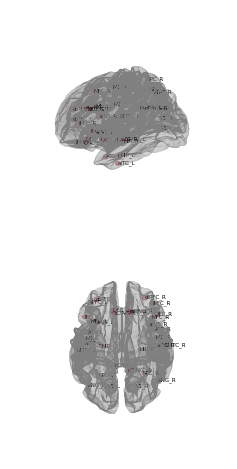

In [20]:
nm.nodeMapping(NetworkDataGeneral, CoM_TAU_Drop, pathNames_TAU_Drop, markerVecTAU, colorVecTAU, thickAtPath_Fig, 
               'Node_3D_Mapping_TAU(Volume_WScore)',
               nodeTransparency = 0.3, atlasTransparency = 0.01, showLabels = 1, surfDisp=None)

## TDP

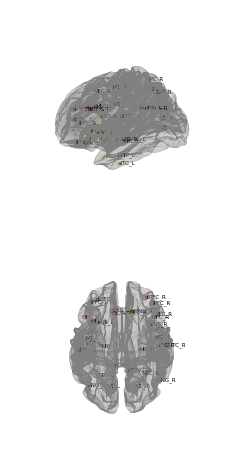

In [21]:
nm.nodeMapping(NetworkDataGeneral, CoM_TDP_Drop, pathNames_TDP_Drop, markerVecTDP, colorVecTDP, thickAtPath_Fig, 
               'Node_3D_Mapping_TDP(Volume_WScore)',
               nodeTransparency = 0.3, atlasTransparency = 0.01, showLabels = 1, surfDisp=None)